<h2> Project - Milestone 2 </h2>

<h3> I. Data handling and cleaning </h3> 


First of all, we import all the packages and useful functions we will need during our analysis.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import folium
import ast
import seaborn as sns
import nltk
import re
import string

from datetime import datetime, date, time
from dateutil.parser import parse

from geopy.extra.rate_limiter import RateLimiter
from geopandas.tools import geocode
from geopy.geocoders import Nominatim

from statsmodels.graphics.mosaicplot import mosaic
from geopy.exc import GeocoderTimedOut
from matplotlib.colors import ListedColormap
from folium.plugins import MarkerCluster

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import RidgeClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from nltk.corpus import stopwords

from collections import Counter 
from itertools import chain

Then, we import the dataset with pandas `read_csv` function, as the size of our data set is relatively small.
After a first analysis of the dataset, we dropped several columns which were not containing any value. We also dropped the `Location` column, since we already have this information into the `Latitude` and `Longitude` columns.

Afterwards, the missing values in the `City` and `State` column were naturally replaced by Chicago and IL. 
Finally, we dropped the facilities with no License number, we only kept the relevant results in the `Results` column and parsed the `Inspection Date` in order to put it in a more standard format.

In [3]:
# Import the data. 
data = pd.read_csv('~/Downloads/chicago-food-inspections/food-inspections.csv')

# Drop the duplicates and discard columns which are not providing useful information. 
data = data.drop_duplicates()
data = data.drop(columns = ['Location', 'Community Areas', 'Census Tracts', 'Wards', "Historical Wards 2003-2015",\
                            "Zip Codes"])

# Fill missing values. 
data.loc[(data['City'].isna())&(~data['Longitude'].isna()),'City']='CHICAGO'
data.loc[(data['State'].isna())&(data['City']=='CHICAGO'),'State']='IL'

# Drop "0" licenses.
data = data[data['License #'] != 0]

# Only consider successful inspections.
data = data[~data['Results'].isin(["Out of Business", "Business Not Located", "No Entry", "Not Ready"])]

# Modify date format in the Inspection Date column
data['Inspection Date']=data['Inspection Date'].apply(lambda d: parse(d))

data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945065,-87.816734
1,2320910,J.T.'S GENUINE SANDWICH,J.T.'S GENUINE SANDWICH,2689893.0,Restaurant,Risk 1 (High),3970 N ELSTON AVE,CHICAGO,IL,60618.0,2019-11-01,License,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.953378,-87.718848
2,2320930,THE MAYFIELD INC,THE MAYFIELD INC,39192.0,Restaurant,Risk 1 (High),6072 S ARCHER AVE,CHICAGO,IL,60638.0,2019-11-01,Canvass,Pass w/ Conditions,40. PERSONAL CLEANLINESS - Comments: FOOD HAND...,41.794753,-87.769377
3,2320960,CARNICERIA Y TAQUERIA TIERRA,CARNICERIA Y TAQUERIA TIERRA,2428138.0,Grocery Store,Risk 1 (High),3312-3314 W NORTH AVE,CHICAGO,IL,60647.0,2019-11-01,Canvass Re-Inspection,Pass,NaN,41.910185,-87.709907
4,2320927,Sayre Language Acad.,Sayre Language Acad.,29271.0,School,Risk 1 (High),1850 N Newland,CHICAGO,IL,60707.0,2019-11-01,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.914124,-87.798757


<h4> Fill in missing latitude and longitude </h4>

In [4]:
locator = Nominatim(user_agent="my-application")
geocode = RateLimiter(locator.geocode)
copy=data.copy()
copy=copy[copy['Latitude'].isna()]
for i in range(len(copy)):
    try:
        copy.iloc[i,-2]=locator.geocode(copy.iloc[i,-10]+copy.iloc[i,-9]).latitude
        copy.iloc[i,-1]=locator.geocode(copy.iloc[i,-10]+copy.iloc[i,-9]).longitude
    except:
        pass

In [5]:
print('number of filled values : {}'.format(len(data[data['Latitude'].isna()])-len(copy[copy['Latitude'].isna()])))
print('number of NaN values remaining: {}'.format(len(data[data['Latitude'].isna()])-len(copy[~copy['Latitude'].isna()])))

number of filled values : 132
number of NaN values remaining: 495


In [6]:
data[data['Latitude'].isna()]=copy
data.to_csv('food-inspectionsbis.csv')

We notice that some `Latitude` and `Longitude` values where missing and so in order to fill them up, we decided to use the geopy library which allows us to get these missing informations from the `Address` column (since there is no missing value in this column). Using this strategy, we were able to fill 132 rows of NaN `Latitude` and `Longitude` values out of 627 values. However, Geopy doesn't manage to fill up the 495 remaining NaN `Latitude` and `Longitude` values.


<h3> II. Data visualization </h3>

First, we start with some basic analysis of our most relevant features in the dataset by looking at their distributions.

<u>**Distributions**</u>

Here, we plot the distributions of the `Risk`, `Facility Type`, `Inspection Type` and `Results` columns.

**Risk**

Text(0, 0.5, 'Risk')

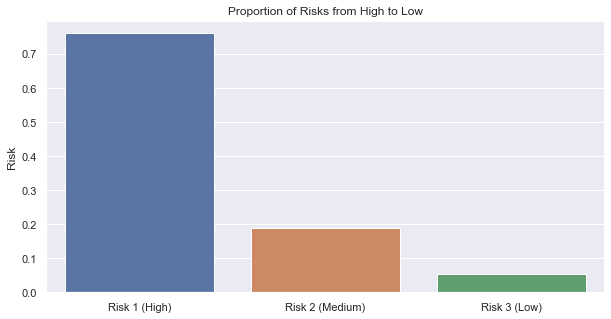

In [66]:
plt.rcParams['figure.figsize'] = (10, 5)
sns.set()
ax=sns.barplot(x=data[data['Risk']!='All']['Risk'].value_counts().index,
            y=data[data['Risk']!='All']['Risk'].value_counts(normalize=True)).set_title('Proportion of Risks from High to Low')
plt.ylabel('Proportion')
plt.ylabel('Risk')

Surprisingly, most facilities are high risk establishments and very few of them are low risk ones. The proportion of medium risk establishments is also quite low.

**Facility type**

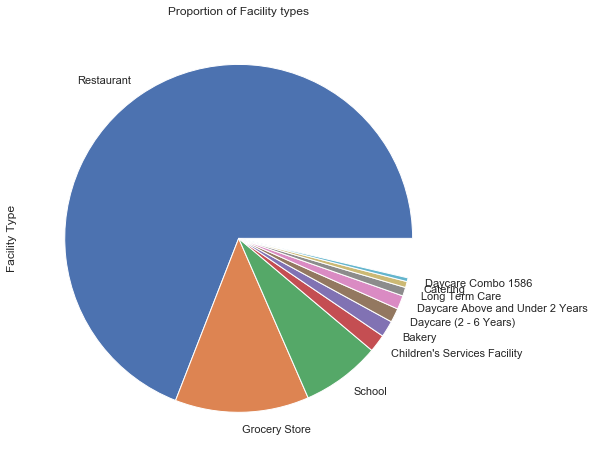

In [55]:
fig, ax = plt.subplots(figsize = (8,8))
facilities=data['Facility Type'].value_counts(normalize=True)[0:10]
plt.title('Proportion of Facility types')
plot=facilities.plot(kind='pie')

Most facilities inspections are for restaurants, grocery stores and schools. These are the three most often inspected facilities in Chicago. Besides, the white part in the pie correspond to the other types of facilities.

**Violations**

Here, we would like to see what is the most frequent violation for each type of facility. This could help us determine whether one type of facility is more likely to present a specific type of violation.

In [56]:
# Return list from series of comma-separated strings.
def chainer(s):
    return list(chain.from_iterable(s.str.split('|')))
 
# Calculate lengths of splits
data = data.dropna()
lens = data['Violations'].str.split('|').map(len)
 
# Create new dataframe, violation-centric, repeating or chaining as appropriate.
res = pd.DataFrame({'Inspection ID': np.repeat(data['Inspection ID'], lens),
                    'Results': np.repeat(data['Results'], lens),
                    'Facility Type':np.repeat(data['Facility Type'], lens),
                    'Violation': chainer(data['Violations'])})
res = res.dropna()

In [57]:
res['Violation Code'] = [a.split('.')[0].strip() for a in res['Violation']]
grouped_violations = res.groupby("Facility Type")['Violation Code'].apply(','.join).reset_index()

In [58]:
def most_frequent(List):
    """
    Compute the most frequent element of a list
    """
    List = list(map(int, List.split(',')))
    occurence_count = Counter(List)
    try:
        return occurence_count.most_common(1)[0][0]
    except IndexError:
        pass
   
   
def from_code_to_violation(code):
    """
    Return the violation associated with the given code
    """
    try:
        return res[res['Violation Code'] == str(int(code))].Violation.tolist()[0].split('-')[0].split('.')[1]
    except IndexError:
        pass

In [59]:
grouped_violations['Most Frequent Code'] = grouped_violations['Violation Code'].apply(most_frequent)
grouped_violations['Most Frequent Violation'] = grouped_violations['Most Frequent Code'].apply(from_code_to_violation)
 
# Keep some facilities that we are interested in
facilities = ['Restaurant', 'Grocery Store', 'School']
grouped_violations.loc[grouped_violations['Facility Type'].isin(facilities)]

,Facility Type,Violation Code,Most Frequent Code,Most Frequent Violation
175,Grocery Store,"5,36,48,55,55,56,3,5,51,5,53,55,55,3,41,51,53,...",34,PLANT FOOD PROPERLY COOKED FOR HOT HOLDING
297,Restaurant,"51,53,58,40,48,55,39,55,10,23,38,43,47,47,49,5...",34,PLANT FOOD PROPERLY COOKED FOR HOT HOLDING
312,School,"10,51,54,54,57,10,55,38,55,51,59,50,59,10,39,5...",35,APPROVED THAWING METHODS USED


**Inspection type**

Text(0, 0.5, 'Inspection Type')

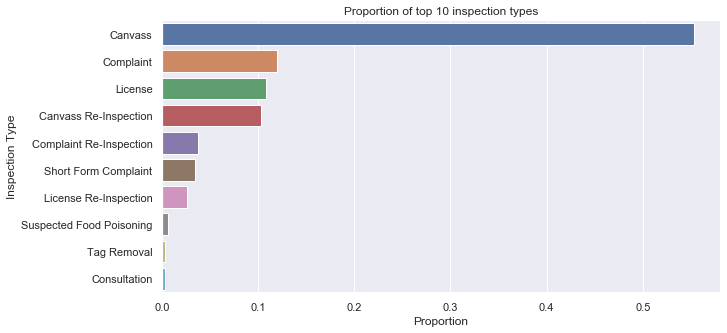

In [60]:
sns.set()
ax=sns.barplot(x=data['Inspection Type'].value_counts(normalize=True)[0:10],
            y=data['Inspection Type'].value_counts(normalize=True)[0:10].index).set_title('Proportion of top 10 inspection types')
plt.xlabel('Proportion')
plt.ylabel('Inspection Type')

The most common type of inspection is Canvass which is performed at a frequency relative to the risk of the establishment as explained in the Inspection type description. The second one is when the inspection is done
as a requirement for the establishment to receive its license to operate since many new food establishments open up in Chicago each year. Complaints are also frequent and it should be interesting to know if these types of inspection are more likely to fail. Finally, inspections for suspect food poisoning (in response to one or more persons claiming to have gotten ill as a result of eating at the establishment), task-force inspections (inspection of a bar or tavern) and Consultation (when the inspection is done at the request of the owner prior to the opening of the establishment) do not occur really often. 
Also, re-inspections can occur for most types of these inspections and are indicated as such.

**Results distribution**

Text(0, 0.5, 'Proportion')

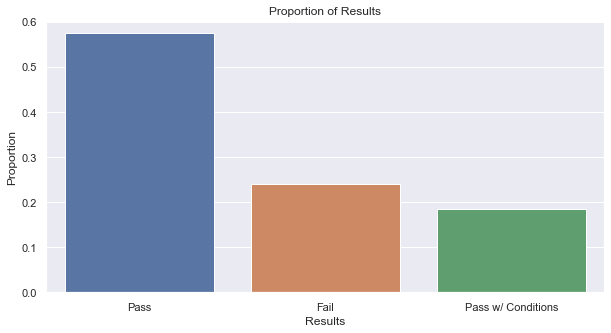

In [61]:
sns.set()
ax=sns.barplot(x=data['Results'].value_counts(normalize=True)[0:10].index,
            y=data['Results'].value_counts(normalize=True)[0:10]).set_title('Proportion of Results')
plt.xlabel('Results')
plt.ylabel('Proportion')

The repartition is not that surprising. Most of the inspections pass, fortunetly. 

<u>**Map of the city of Chicago**</u>

In [21]:
#folium.__version__ == '0.10.0'
CHICAGO_COORDINATES = (41.8781, -87.6298)
# for speed purposes
MAX_RECORDS = 1000
  
# create empty map zoomed in on San Francisco
m = folium.Map(location=CHICAGO_COORDINATES, zoom_start=11)
mc = MarkerCluster()
# add a marker for every record in the filtered data, use a clustered view
for i in range(0,500):# here we plot only 500 establisments but we will ultimately plot them all
    mc.add_child(folium.Marker([data[data['Latitude'].notnull()].iloc[i,-2],
                                data[data['Latitude'].notnull()].iloc[i,-1]], 
                               popup=data[data['Latitude'].notnull()].iloc[i,1]))
m.add_child(mc)

m.save("map.html")

To visualise the map : <a href="map.html">link</a>

<u>**Chain restaurants**</u>

We thought it could be interesting to get more insights on chain restaurants inspections since these restaurants are supposed to run by stricter rules and to pay attention to be careful for their inspections since a bad report could jeopardize the whole chain.
We first decided to select the top 10 chain restaurants and to identify chain restaurants, we selected the restaurants which have more than 20 establishments under the same DBA name across the city. We then plotted the evolution of the mean risk troughout the years.

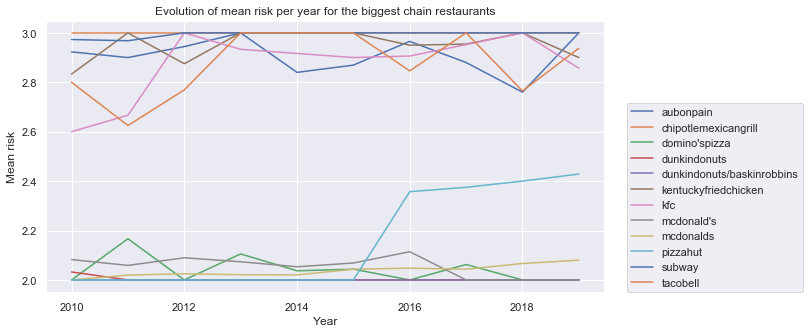

In [62]:
sns.set()
data_restaurant=data.copy()[data['Facility Type']=='Restaurant']

# Cleaning of DBA Names 
data_restaurant['Inspection Date']=data_restaurant['Inspection Date'].apply(lambda d: d.year)
data_restaurant['DBA Name']=data_restaurant['DBA Name'].str.replace(r" ","").replace("'","").replace("restaurant","")
data_restaurant['DBA Name']=data_restaurant['DBA Name'].str.lower()

# Mapping risks from 1 being low to 3 being high
data_restaurant['Risk']=data_restaurant['Risk'].map({'Risk 1 (High)':3, 'Risk 2 (Medium)':2,'Risk 3 (Low)':1})

# Selecting chain restaurants
resto=data_restaurant.groupby('DBA Name')['Address'].nunique().sort_values(ascending=False)
data_restaurant=data_restaurant[data_restaurant['DBA Name'].isin(resto[resto.values>20].index.tolist())]

# Plotting risks evolution
fig, ax = plt.subplots()
for key, grp in data_restaurant.groupby(['DBA Name']):
    ax.plot(grp.groupby('Inspection Date')['Risk'].mean().index.tolist(),
            grp.groupby('Inspection Date')['Risk'].mean().values.tolist(),label=key)
plt.legend(loc=(1.04,0))
plt.title('Evolution of mean risk per year for the biggest chain restaurants')
plt.xlabel('Year')
plt.ylabel('Mean risk')
plt.show()

Surprisingly, although half of the top 10 chain restaurants have a medium risk, the other half of chain restaurants have a high risk and non have a low risk. However, having a high risk doesn't mean that the inspection will fail but we should dig up a bit more into this.

<u> **Correlations** </u>

We first want to create a Violation-centric data frame, in order to study the effect of the number of violations on the results of the inspections. 

What we do : for each inspection, we create a new row containing only one violation in the column of violation. Thus, we will be able to see if the number of violations will influence the result of an inspection. 

In [63]:
# Violation centered data frame. 
convert_dict = {'Violations': str}  
data = data.astype(convert_dict)

# For each inspection, we split the violations commun in order to have one violation per row. 
Violations = pd.DataFrame(data['Violations'].str.split('|').tolist(),index=data['Inspection ID']).stack()
Violations = Violations.reset_index()[[0, 'Inspection ID']]
Violations.columns = ['Violations', 'Inspection ID']

# We drop, from the original data frame, the Violations column. 
df = data.drop('Violations', axis=1)

# Finally, we merge, the data frames, so we have all the information of the inspection, but a violation per row. 
Violations= pd.merge(df, Violations, on='Inspection ID', right_index=True)
Violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Violations
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01,Canvass,Pass w/ Conditions,41.945065,-87.816734,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01,Canvass,Pass w/ Conditions,41.945065,-87.816734,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPL...
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01,Canvass,Pass w/ Conditions,41.945065,-87.816734,56. ADEQUATE VENTILATION & LIGHTING; DESIGNAT...
1,2320910,J.T.'S GENUINE SANDWICH,J.T.'S GENUINE SANDWICH,2689893.0,Restaurant,Risk 1 (High),3970 N ELSTON AVE,CHICAGO,IL,60618.0,2019-11-01,License,Pass,41.953378,-87.718848,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...
1,2320910,J.T.'S GENUINE SANDWICH,J.T.'S GENUINE SANDWICH,2689893.0,Restaurant,Risk 1 (High),3970 N ELSTON AVE,CHICAGO,IL,60618.0,2019-11-01,License,Pass,41.953378,-87.718848,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ..."


Now, we want to see if the number of violations is correlated or not with the result of an inspection. For this, we will count the number of violations per inspection and aggregate by the result of the inspection. We will thus obtain, for each result, the number of violations those inspections received. 

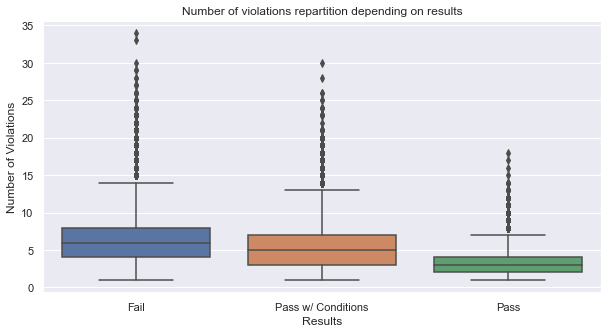

In [67]:
sns.set()
# A data frame containing, for each inspection, the number of violations. 
df=pd.DataFrame({'Inspection ID' :Violations['Inspection ID'].value_counts().keys().tolist()\
                 ,'Number of Violations' :Violations['Inspection ID'].value_counts().values.tolist()})

# Keep only the most relevant results. 
data = data[data["Results"].isin(["Pass", "Pass w/ Conditions", "Fail"])]

# Merge the newly-created data frame with the old one, on inspection ID, and keepint only the Results column. 
df=pd.merge(df, pd.DataFrame(data[['Inspection ID','Results']]), on='Inspection ID')
df=df.dropna()

# Plot the boxplots
ax = sns.boxplot(x="Results", 
                 y="Number of Violations",
                 data=df).set_title('Number of violations repartition depending on results')

For the data set, we only look at the 3 most relevant categories regarding the `Results` : Fail, Pass and Pass with conditions. We plotted the boxplots corresponding to those 3 categories representing the number of violations. 
Without any surprise, the failed inspections are the ones with most violations. An inspection with more violations is thus most likely to fail the inspection. Nevertheless, we can observe some outliers on the boxplots : some inspections with a high number of violations still passed the inspection. One explanation for this is that some violations are more critical than others and are more likely to make an inspection fail. Furthermore, the result is determined by a combination of several violations, and not by the cumulated effect of each violation independently. Finally, the severity of a violation varies from an inspection to another : one facility may have not fulfilled several aspects of the violation. 

<u>**Analysis of results distribution**</u>

We now want to see how the results are distributed among the top inspection and facility types. To do so, we decided to plot two mosaic plots, one for the inspections, one for the facility types, with respect to the results. The mosaic plots allow us to observe the proportion of each facility/inspection type, and the proportion of each results conditional to this inspection/facility type (area of the rectangles). Here we do not show the residuals, because we just want to observe the different proportions of the results (and there is no reason to consider the null hypothesis -- independence between facility/inspection type and results, the observed data being 'distant' from that hypothesis). We also use the gap parameter to make the mosaic plot more readable (high proportion of one type, the others are shrunken). 

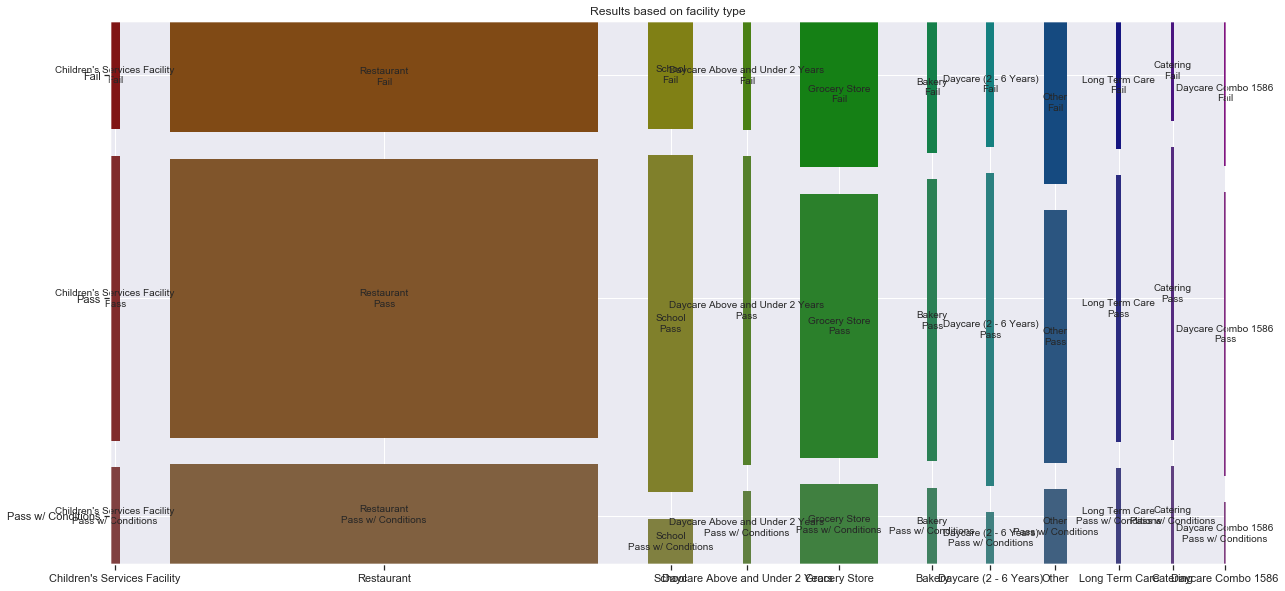

In [68]:
sns.set()
df = data.copy()

# Select the top 10 most represented facilities, assign the others to Other category.
top10_facilities = df["Facility Type"].value_counts().keys().tolist()[:10]
df["Facility Type"] = df["Facility Type"].apply(lambda x : x if x in top10_facilities else "Other")
#df["Results"] = df.Results.apply(lambda v: "Pass" if v == "Pass w/ Conditions" else v)


# Plot a mosaic plot.
plt.rcParams['figure.figsize'] = (20, 10)
fig, rects = mosaic(df, ["Facility Type", "Results"], title='Results based on facility type', gap =0.08)
plt.show()

What we can observe from the previous plot is that : 
- Schools,Restaurants and Children's services (including daycare) usually have an important proportion of Pass
- Grocery Stores and Mobile Food Dispensers have the most failed inspections. 

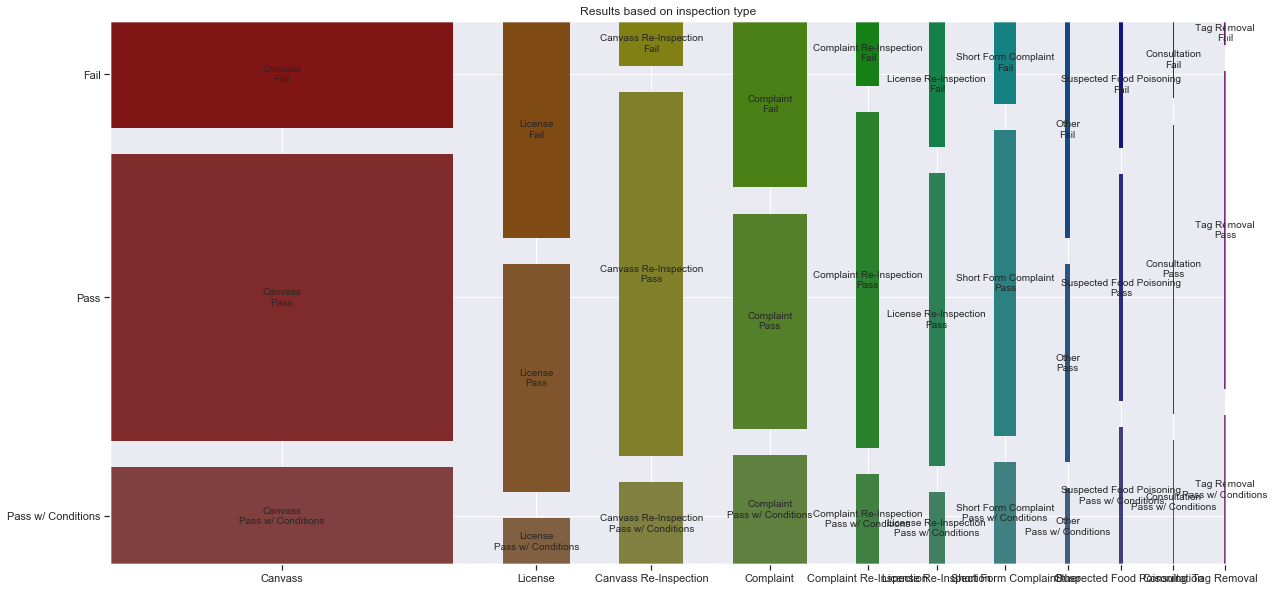

In [69]:
sns.set()
df2 = data.copy()

# Select the top 10 most represented inspection types, assign the others to Other category.
top10_inspections = df2["Inspection Type"].value_counts().keys().tolist()[:10]
df2["Inspection Type"] = df2["Inspection Type"].apply(lambda x : x if x in top10_inspections else "Other")
#df2["Results"] = df2.Results.apply(lambda v: "Pass" if v == "Pass w/ Conditions" else v)

# Plot a mosaic plot.
plt.rcParams['figure.figsize'] = (20, 10)
fig, rects = mosaic(df2, ["Inspection Type", "Results"], title='Results based on inspection type', gap =0.08)
plt.show()

What we can observe from the previous plot is that : 
- the most failed inspections concern Licenses, Complaints, Food Poisoning and License-task force
- the most passed inspections are mostly the re-inspections : we can deduce that facilities take into account the violations they received and correct them.

<u> **Severity of the violations** </u>

We have seen before that the number of violations can be related with the result of an ispection, but some violations can be more serious than others. In this part, we will try to highlight the differences between violations.

First, we know that the violation code has changed on 7/1/2018, thus we will separate our data frame in two different data frames, according to this date. 

In [70]:
# Create a date stamp. 
stamp = pd.datetime(2018,7,1)

# Seperate the two data frames. 
data1 = data[(data["Inspection Date"] <= stamp)]
data2 = data[(data["Inspection Date"] > stamp)]

# Drop the empty values. 
data1 = data1.dropna(subset=["Violations"])
data2 = data2.dropna(subset=["Violations"])

We now create a function that will explode the violation column adn keep only the numbers of those violations, since each violation can be uniquely identified by this number. We discard the comments. 

In [73]:
def violation_number(x) : 
    """
    Explodes the Violations column into several rows and replaces each violation by its number
    Arguments : x is the data frame
    Results : y data frame with column exploded
    """
    
    y = x.copy()
    
    # Get a list of the different violations for each inspection. 
    y["Violations"] = y.Violations.apply(lambda x : x.split("|"))
    
    # Discard the comments.
    y["Violations"] = y.Violations.apply(lambda x : [elt.split(" - Comments: ")[0] for elt in x])
    
    # Explode and keep only the numbers
    y = y.explode("Violations")

    y_interm = y.copy()
    y["Violations"] = y.Violations.apply(lambda x : x.split(".")[0].strip())
    
    return y, y_interm

In [74]:
# Apply the function to the 2 data frames.
data1_, data1_interm = violation_number(data1)
data2_, data2_interm = violation_number(data2)
data1_.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Latitude,Longitude,Violations
0,2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,41.691077,-87.64249,30
1,2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,41.691077,-87.64249,32
2,2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,41.691077,-87.64249,33
3,2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,41.691077,-87.64249,34
4,2182154,THE GOOD LIFE SOUL FOOD RESTAURANT,THE GOOD LIFE SOUL FOOD RESTAURANT,2551347.0,Restaurant,Risk 1 (High),11142 S HALSTED ST,CHICAGO,IL,60628.0,2018-06-29,Canvass Re-Inspection,Pass,41.691077,-87.64249,35


We now want to keep only the `Violations`, `Risk` and `Results` columns. First, let's focus on the first data set, the one containing the violations before the changes. 

We create in the following cell a data frame which will contain, for each violation, the proportion of failed, passed, and passed with condition inspections. 

In [75]:
data1_ = data1_[['Violations', 'Risk', 'Results']]
data1_ = data1_.dropna(subset = ["Results", "Risk"])

# Count, for each result, the number of occurences of each violation. 
Passed_list = data1_[data1_["Results"] == "Pass"].Violations.value_counts().keys().tolist()
Passed_counts = data1_[data1_["Results"] == "Pass"].Violations.value_counts().tolist()

Failed_list = data1_[data1_["Results"] == "Fail"].Violations.value_counts().keys().tolist()
Failed_counts = data1_[data1_["Results"] == "Fail"].Violations.value_counts().tolist()

Passedcond_list = data1_[data1_["Results"] == "Pass w/ Conditions"].Violations.value_counts().keys().tolist()
Passedcond_counts = data1_[data1_["Results"] == "Pass w/ Conditions"].Violations.value_counts().tolist()

# Create data frames containing the violation and the counts for each result.
Passed_df = pd.DataFrame({"Violations" : Passed_list, "count_passed" : Passed_counts})
Failed_df = pd.DataFrame({"Violations" : Failed_list, "count_failed" : Failed_counts})
Passedcond_df = pd.DataFrame({"Violations" : Passedcond_list, "count_cond" : Passedcond_counts})

# Merge. 
merged = pd.merge(Passed_df,Failed_df,how = "outer", on = 'Violations')
merged = pd.merge(merged,Passedcond_df, how = "outer", on = "Violations")

# Fill the missing values with 0. 
merged = merged.fillna(0)

# Compute, for each violation, the proportion of inspections passed, failed and passed with conditions. 
merged["total"] = merged.count_passed + merged.count_failed + merged.count_cond

merged["%passed"] = round(100* merged.count_passed / merged.total)
merged["%failed"] = round(100*merged.count_failed / merged.total)
merged["%cond"]  = round(100*merged.count_cond / merged.total)

# Keep only the percentages. 
merged = merged[["Violations", "%passed", "%failed", "%cond"]]

In [76]:
# Discard nans due to the explode 
merged = merged[merged["Violations"] != "nan"]
merged.head()

,Violations,%passed,%failed,%cond
0,34,61.0,27.0,12.0
1,35,60.0,28.0,12.0
2,33,61.0,26.0,13.0
3,32,59.0,27.0,13.0
4,38,59.0,29.0,12.0


In [77]:
# List of violations for period 1, will be useful later. 
list_of_violations1 = merged.Violations.tolist()

Now, let's try to apply a clustering method to our violations. We want to see if we can highlight different categories of violations, from least to most severe. For this, we are using a KMeans clustering method.

Text(0, 0.5, '% Failed')

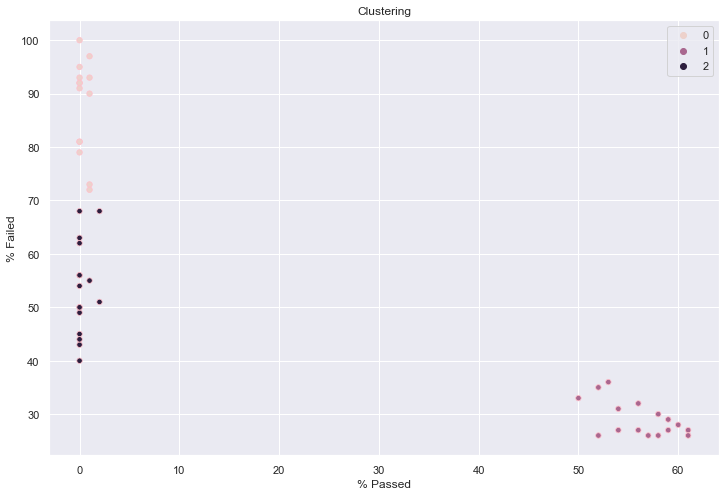

In [92]:
sns.set()
# Use KMeans clustering method
X = np.array(merged[["%passed", "%failed", "%cond"]])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Plot in 2-dimensions, passed and failed, since the third one is directly determined from the 2 others.
plt.rcParams['figure.figsize'] = (12,8)
ax=sns.scatterplot(X[:,0], X[:,1],hue = kmeans.labels_,s=30,edgecolor='pink').set_title('Clustering')
plt.xlabel('% Passed')
plt.ylabel('% Failed')

Now that we have this clustering, we create a new data frame containing for each violation its degree of severity : normal will be for the least serious type of violation, critical for the most, and severe the in-between (but critical because very few passed)

In [93]:
category_df = pd.DataFrame({"Violation" : merged["Violations"].tolist(), "Category" : kmeans.labels_ })
category_df["Category"] = category_df["Category"].map({1 : "Normal", 0 : "Critical", 2 : "Severe"})

We now print the different categories for each violation and also the mapping between the violations numbers and their naming. 

In [94]:
category_df

,Violation,Category
0,34,Normal
1,35,Normal
2,33,Normal
3,32,Normal
4,38,Normal
5,41,Normal
6,36,Normal
7,30,Normal
8,40,Normal
9,31,Normal


In [95]:
data1_interm.Violations.str.strip().unique()

array(['30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED',
       '32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED',
       '33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS',
       '34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED',
       '35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS',
       '36. LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED',
       '38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED',
       '41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED',
       '43. FOOD (ICE) DISPENSING UTENSILS, WASH CLOTHS PROPERLY STORED',
       '45. FOOD HANDLER REQUIREMENTS MET',
       '11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBL

We thus defined 3 categories of violations based on the clustering done above :  <br>
<b><u> Normal or minor violations </u> </b> <br> 
Those violations do not concern food directly and are not a direct threat to people's health. They mostly concern : 
- the premises : floor, ceiling, ventilation, toilets 
- acces to only authorized personnel in the food area
- cleaning, the ustensils, the different restrictions
<br> 

<b><u> Severe violations </u> </b> <br>
These violations have an important amount of failed and passed with conditions proportions as they can jeopardize people's health. They mostly concern : 
- the storage of the food : good temperature, thawning, labelling of the food
- contamination issues : toxic elements are well stored, people with infections are kept away from the food area 
- hygienic practices
- presence of a food manager on site 
- prohibition of reserving unwrapped food
- smoking restrictions 
<br> 

<b><u> Critical violations </u></b> <br>
These violations seriously endanger customer's health and can be at the origin of food-related illness. They concern : 
- food protection and storage : protection from rodents, stored at the right temperature
- rodent/insects/other animals infestation
- handling of ustensils and dishes : washed, rinsed and scraped
- water sources : hot water, city pressure
<br> 

This clustering was realised based on the proportion of passed/failed/passed with conditions inspections. Our categories broadly match a classification we found on the city of Chicago website : <u><a href="https://webapps1.chicago.gov/healthinspection/Code_Violations.jsp?fbclid=IwAR0NMn4WEEQqHelYLRwh-z1czAhMinI0ufWgbK33bfjxA6B7sn0qlCTiraQ#1crit">link</a></u>

Our method to classify the violations (clustering by kNN) actually makes sense based on the website : minor violations have a small rate of fail and an important proportion of pass (our first cluster), severe violations have an important amount of passed with conditions (if a severe violation occurs, the facility gets a passed with conditions if this violations is corrected - this is our second cluster). Finally, the critical violations have a proportion of failed inspections superior to 70% - our third cluster. 

Let's now do the same type of clustering for the second part of the data set.

In [96]:
data2_ = data2_[['Violations', 'Risk', 'Results']]
data2_ = data2_.dropna(subset = ["Results", "Risk"])

# Count, for each result, the number of occurences of each violation. 
Passed_list = data2_[data2_["Results"] == "Pass"].Violations.value_counts().keys().tolist()
Passed_counts = data2_[data2_["Results"] == "Pass"].Violations.value_counts().tolist()

Failed_list = data2_[data2_["Results"] == "Fail"].Violations.value_counts().keys().tolist()
Failed_counts = data2_[data2_["Results"] == "Fail"].Violations.value_counts().tolist()

Passedcond_list = data2_[data2_["Results"] == "Pass w/ Conditions"].Violations.value_counts().keys().tolist()
Passedcond_counts = data2_[data2_["Results"] == "Pass w/ Conditions"].Violations.value_counts().tolist()

# Create data frames containing the violation and the counts for each result.
Passed_df = pd.DataFrame({"Violations" : Passed_list, "count_passed" : Passed_counts})
Failed_df = pd.DataFrame({"Violations" : Failed_list, "count_failed" : Failed_counts})
Passedcond_df = pd.DataFrame({"Violations" : Passedcond_list, "count_cond" : Passedcond_counts})

# Merge. 
merged = pd.merge(Passed_df,Failed_df,how = "outer", on = 'Violations')
merged = pd.merge(merged,Passedcond_df, how = "outer", on = "Violations")

# Fill the missing values with 0. 
merged = merged.fillna(0)

# Compute, for each violation, the proportion of inspections passed, failed and passed with conditions. 
merged["total"] = merged.count_passed + merged.count_failed + merged.count_cond

merged["%passed"] = round(100* merged.count_passed / merged.total)
merged["%failed"] = round(100*merged.count_failed / merged.total)
merged["%cond"]  = round(100*merged.count_cond / merged.total)

# Keep only the percentages. 
merged = merged[["Violations", "%passed", "%failed", "%cond"]]

In [97]:
# Discard nans due to the explode 
merged = merged[merged["Violations"] != "nan"]
merged.head()

,Violations,%passed,%failed,%cond
0,55,14.0,32.0,54.0
1,47,11.0,32.0,57.0
2,51,13.0,32.0,55.0
3,56,12.0,31.0,56.0
4,49,12.0,35.0,53.0


Text(0, 0.5, '% Failed')

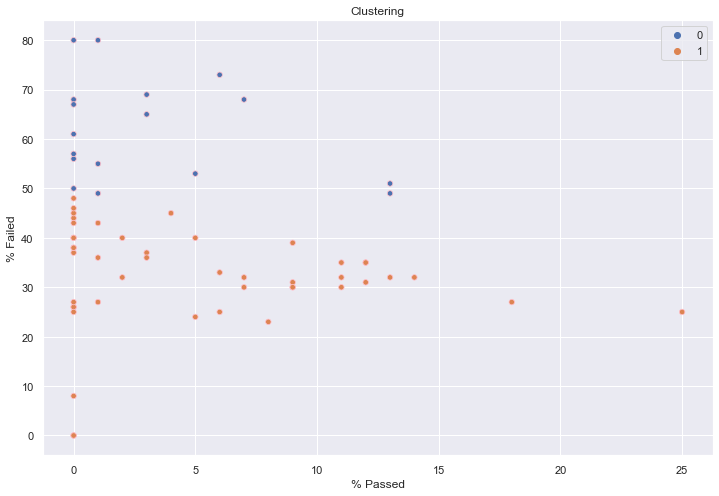

In [102]:
sns.set()
# Use KMeans clustering method
X = np.array(merged[["%passed", "%failed", "%cond"]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

# Plot in 2-dimensions, passed and failed, since the third one is directly determined from the 2 others.
plt.rcParams['figure.figsize'] = (12,8)
ax=sns.scatterplot(X[:,0], X[:,1],hue = kmeans.labels_,s=30,edgecolor='pink').set_title('Clustering')
plt.xlabel('% Passed')
plt.ylabel('% Failed')

For the second part of the dataframe, the clustering is less obvious : we observe a serous decay in the proportion of passed violations. We tried to cluster the violations in 2, 3 and 4 clusters, but there is always a cluster containing only 2 violations. We decided to stick with 2 clusters. 

In [103]:
category_df_2 = pd.DataFrame({"Violation" : merged["Violations"].tolist(), "Category" : kmeans.labels_ })
category_df_2["Category"] = category_df_2["Category"].map({1 : "Normal", 0 : "Critical"})

In [104]:
category_df_2[category_df_2["Category"] == "Critical"]

,Violation,Category
10,38,Critical
16,16,Critical
18,54,Critical
19,48,Critical
20,52,Critical
26,28,Critical
31,33,Critical
33,1,Critical
35,15,Critical
38,60,Critical


In [105]:
data2_interm.Violations.str.strip().unique()

array(['5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS',
       '10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE',
       '56. ADEQUATE VENTILATION & LIGHTING; DESIGNATED AREAS USED',
       '51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES',
       '53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED',
       '58. ALLERGEN TRAINING AS REQUIRED', '40. PERSONAL CLEANLINESS',
       '48. WAREWASHING FACILITIES: INSTALLED, MAINTAINED & USED; TEST STRIPS',
       '55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN',
       '54. GARBAGE & REFUSE PROPERLY DISPOSED; FACILITIES MAINTAINED',
       '57. ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING',
       '39. CONTAMINATION PREVENTED DURING FOOD PREPARATION, STORAGE & DISPLAY',
       '52. SEWAGE & WASTE WATER PROPERLY DISPOSED',
       '23. PROPER DATE MARKING AND DISPOSITION',
       '38. INSECTS, RODENTS, & ANIMALS NOT PRESENT',
       '43. IN-USE UTENSILS: PROPERLY STORED',
       '47. FOOD & 

We identify the same patterns as before, the most critical violations include real dangers of customer's health : presence of rodents (38), handling of toxic substances (28), temperature control (33), water source (31), cooking conditions (34). 

<u> **Localization of risks - Map of Chicago** </u> 

As the data file contains the latitude and longitude for a large majority of the facilities inspected, we wanted to analyse the localisation of the different risks. 

In [108]:
data.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude
0,2320971,JUMPSTART EARLY LEARNING ACADEMY,JUMPSTART EARLY LEARNING ACADEMY,2589822.0,Children's Services Facility,Risk 1 (High),7559 W ADDISON ST,CHICAGO,IL,60634.0,2019-11-01,Canvass,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.945065,-87.816734
1,2320910,J.T.'S GENUINE SANDWICH,J.T.'S GENUINE SANDWICH,2689893.0,Restaurant,Risk 1 (High),3970 N ELSTON AVE,CHICAGO,IL,60618.0,2019-11-01,License,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.953378,-87.718848
2,2320930,THE MAYFIELD INC,THE MAYFIELD INC,39192.0,Restaurant,Risk 1 (High),6072 S ARCHER AVE,CHICAGO,IL,60638.0,2019-11-01,Canvass,Pass w/ Conditions,40. PERSONAL CLEANLINESS - Comments: FOOD HAND...,41.794753,-87.769377
4,2320927,Sayre Language Acad.,Sayre Language Acad.,29271.0,School,Risk 1 (High),1850 N Newland,CHICAGO,IL,60707.0,2019-11-01,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.914124,-87.798757
5,2320918,BEEFSTEAK,BEEFSTEAK,2698445.0,Restaurant,Risk 1 (High),303 E SUPERIOR ST,CHICAGO,IL,60611.0,2019-11-01,License,Pass,39. CONTAMINATION PREVENTED DURING FOOD PREPAR...,41.895692,-87.620143


(41.5, 42.1)

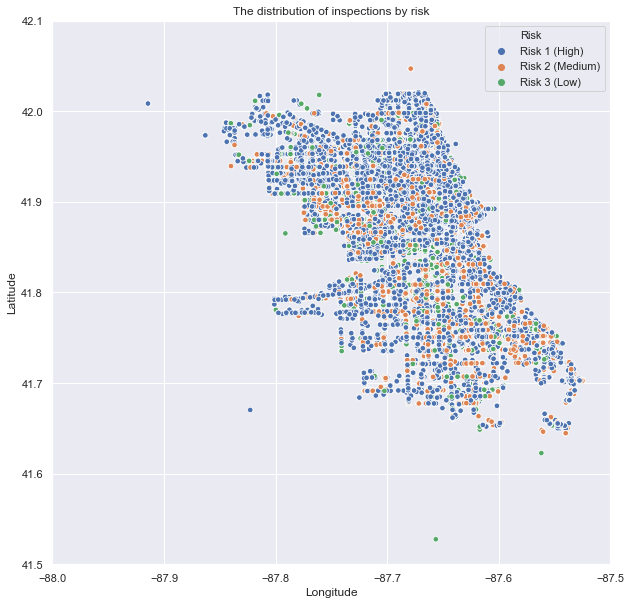

In [141]:
sns.set()
fig, ax = plt.subplots(figsize = (10,10))
ax=sns.scatterplot(x='Longitude',y='Latitude',hue= 'Risk',data=data,s=30).set_title("The distribution of inspections by risk")
plt.xlim([-88,-87.5])
plt.ylim([41.5,42.1])

The map above shows that food establishments with low and medium risk tend to cluster together, especially towards the central parts of the city. This indicates perhaps establishments located in richer areas, which naturally will have more funds to allow for maintaining a better quality of the overall services and locations which they provide.

<u> **Time patterns** </u> 

We now want to know if there exist some changes over the years in the distribution of the results of the inspections.

Text(0.5, 1.0, 'Evolution of the percentage of inspection results over the years')

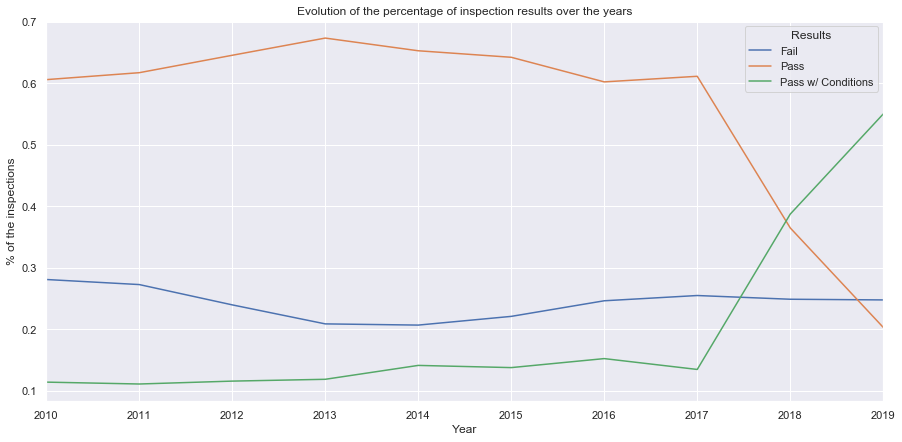

In [124]:
sns.set()
data_year = data.copy()

data_year['Year']=data_year['Inspection Date'].apply(lambda d: d.year)

# Count for each month (over all the years), the number of passed / failed inspections.
passed_grouped = data_year[(data_year.Results.str.contains("Pass")) | \
                           (data_year.Results.str.contains("Fail"))].groupby(["Year", "Results"]).count()
passed_per_year = passed_grouped.groupby(level=[0]).apply(lambda g: g / g.sum())

# Plot. 
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('Year')
ax.set_ylabel('% of the inspections')
passed_per_year['Risk'].unstack().plot(ax=ax)
plt.title('Evolution of the percentage of inspection results over the years')

A change in the results occurs between 2017 and 2018 : less pass and more pass with conditions. It is linked to the change in the violations code in July 2018, and inspections seem to have become stricter.

In the last part of this section, we wondered if there exist seasonal patterns in our data, for instance, if we have a change in the proportion of passed / failed inspections during certain months of the year. 

Text(0.5, 1.0, 'Evolution of the percentage of inspection results over the months')

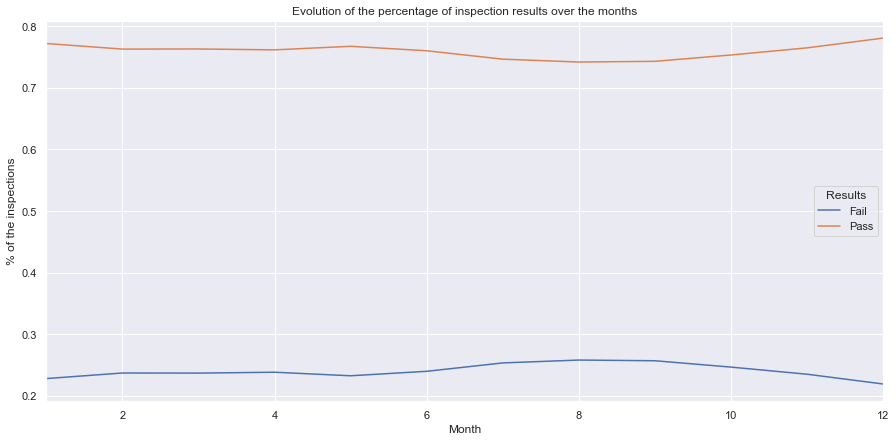

In [127]:
sns.set()
# Map the Pass with conditions to pass and select the month for each inspection. 
data_month = data.copy()
data_month['Month']=data_month['Inspection Date'].apply(lambda d: d.month)
data_month.Results = data_month.Results.apply(lambda v: "Pass" if v == "Pass w/ Conditions" else v)

# Count for each month (over all the years), the number of passed / failed inspections.
passed_grouped = data_month[(data_month.Results.str.contains("Pass")) | \
                            (data_month.Results.str.contains("Fail"))].groupby(["Month", "Results"]).count()
passed_per_year = passed_grouped.groupby(level=[0]).apply(lambda g: g / g.sum())

# Plot. 
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('Month')
ax.set_ylabel('% of the inspections')
passed_per_year['Risk'].unstack().plot(ax=ax)
plt.title('Evolution of the percentage of inspection results over the months')

The plot above, even though simple, illsutrates there is seasonality in the months of July, August and September. More precisely, during these months it seems that the average percentage of Pass inspections (over all years) decreases while the Fail increases. In retrospective this is reasonabel as the hot summer months tend to make it more difficult to store meat and other animal-derivide incredients, avoid rodents and insects, as well as maintain a comfotable temperature for the customers. Note that we considered both Pass and Pass w/ Conditions to be a Pass.

<h3> III. Predictive models </h3>

<h4> First model based on the violations </h4> 

One approach in which we can use the dataset to predict whether an inspection will pass or fail is to use the violations as features. Namely, we map each violation to a column that can store binary values: 1.0 if the violation is identified during the current inspection, 0.0 otherwise. We also map the results of the inspections to either 'Pass' or 'Fail', thus considering 'Pass w/ Condtiotions' to still be a 'Pass'. These results are also encoded as binary values (1.0 or 0.0) and will be used as truth values/labels.
One major problem in building the features in this way is the fact that in July 2018 the old violations were replaced by entiredly new ones. The same numbers no longer refer to the same violations or related violations, hence the dataset has to be split in 2 parts (before and after July 2018). Unfortunately, this means that 2 separate models have to be trained on the 2 datasets, but for now we will only attempt training one model on the old violations dataset given that it is much larger. Naturally, if this model performs well, it is expected that the model trained on the newviolations dataset will also perform well given that the features are built in the same way.

In [ ]:
# Function to get the violations from the 'Violation` column and convert them into binary features using one hot encoding.
def get_violations_features(violations):
    binary_values_row = pd.Series([])
   
    if type(violations) == str:
        violations = violations.split(" | ")
       
        for violation in violations:
            idx = "v_" + violation.split(".")[0]
            binary_values_row[idx] = 1.0
           
    return binary_values_row
 

# Convert the violations to binary values: 1.0 for present vioaltion, 0.0 for missing.
binary_values_data = data1.Violations.apply(get_violations_features).fillna(0.0)
 
# Column names for 'critical' violations.
critical_cols = [("v_" + str(number)) for number in range(1, 15)]
 
# Column names for 'serious' violations.
serious_cols = [("v_" + str(number)) for number in range(15, 30)]
 
# Column names for 'minor' violations.
minor_cols = [("v_" + str(number)) for number in range(30, 45)]
minor_cols.append("v_70")
 
# Store all column names in a single list.
all_cols = []
all_cols.extend(critical_cols)
all_cols.extend(serious_cols)
all_cols.extend(minor_cols)
 
# Dataframe containing binary values for each violation identified during an inspection.
binary_features = pd.DataFrame(binary_values_data, columns=all_cols)
 
# Add the 'Inspection ID' to identify a particular inspection.
binary_features["Inspection ID"] = cata1["Inspection ID"]
 
# Add the 'Results' column to use as truth values/labels.
binary_features["Results"] = cata1["Results"]
 
# Map 'Pass w/ Conditions' to 'Pass' as this is a binary classification problem.
binary_features.Results = binary_features.Results.apply(lambda v: "Pass" if v == "Pass w/ Conditions" else v)
 
# Keep only 'Pass' and 'Fail' inspections entried.
binary_features = binary_features[(binary_features.Results.str.contains("Pass")) | (binary_features.Results.str.contains("Fail"))]
 
# Map the 'Results' values to binary values as well: 1.0 for 'Pass', 0.0 for 'Fail'.
binary_features.Results = binary_features.Results.apply(lambda v: 1.0 if v == "Pass" else 0.0)
 

The model which performed best at predicting wether an inspection will pass or fail is the multiplayer perceptron classifier with an accuracy of 94% on the test set.

In [41]:
# Matrix containing the binary features for each inspection. Each row corresponds to an inspection.
X = binary_features.loc[:, (binary_features.columns != "Results") & (binary_features.columns != "Inspection ID")]
 
# Vector containing the labels/truth values.                                                  
y = binary_features.Results
 
# Split the dataset into training and training sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
 
# Train the model on the training set.
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(10, 5), activation='relu', learning_rate='adaptive')\
        .fit(X_train, y_train)
                                                 
#Evaluate the model's accuracy on the test set.
clf.score(X_test, y_test)

0.9414534041525833

<h4> Second model using all the features </h4> 


For this model, we wanted to use not only the violations, but transform all the other meaningful categorical features (such as facility type, inspection type) into new numerical features, always by the one-hot-encoding method (one new feature by category, fill with 1 if the inspection belongs to the category, 0 otherwise). Furthermore, we keep the latitude and longitude as features (already numerical) and we keep the risk number. 
We map the Passed with conditions result to Pass in order to apply a Logistic Regression. Since the violations changed after 7/1/2018, we will work again on the two splitted data sets. 


In [162]:
# Keep the meaningful features. 
data1_model = data1[["Inspection ID", "Facility Type", "Risk", "Inspection Type", "Results", "Violations",\
                     "Latitude", "Longitude"]]

We define two one-hot-encoding functions which will allow us to transofrm the categorical features into numerical (binary) features

In [163]:
def one_hot_encoding(x, column) : 
    """ 
    x is the pd DataFrame we work on
    column is the column we want to do the one-hot-encoding on
    """

    y = x.copy()
    
    #Build new columns
    for elt in y[column].unique() : 
        y[str("feature_"+elt)] = (y[column] == elt).astype(int)
        
    return y

In [164]:
def one_hot_encoding_violations(x, violations) : 
    """ 
    x is the pd DataFrame we work on
    Does one-hot-encoding on the violations -- different from previous function because we can have several violation
    """
    
    y = x.copy()
    
    for violation in violations : 
        y[str("feature_" + violation)] = (y.Violations.str.contains(violation)).astype(int) 
        
    return y

Let's deal with the facility type column first. 

In [165]:
# Keep only the top 10 facilities identified before, map the others to the Other category. 
data1_model["Facility Type"] = data1_model["Facility Type"].apply(lambda x : x if x in top10_facilities else "Other")

# One-hot-encoding on the facility type column, then drop it. 
data1_model = one_hot_encoding(data1_model,"Facility Type")
data1_model = data1_model.drop(columns = ["Facility Type"])

C:\Users\anna-\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We do the same for the inspectipn type. 

In [166]:
# Compute and keep only the top 10 inspections, map to Others otherwise. 
top10_inspections = data1_model["Inspection Type"].value_counts().keys().tolist()[:10]
data1_model["Inspection Type"] = data1_model["Inspection Type"].apply(lambda x : x if x in top10_inspections else "Other_inspection")

# One-hot-encoding and drop. 
data1_model = one_hot_encoding(data1_model,"Inspection Type")
data1_model = data1_model.drop(columns=["Inspection Type"])


For the risk, we only keep the relevant Risk levels and keep the number as a numerical feature. 

In [167]:
# Remove the All for the risk column, ambiguous. 
data1_model["Risk"] = data1_model[data1_model['Risk'] != 'All']['Risk']

# Remove the rows containing nas for the columns risk and facility type.
data1_model = data1_model.dropna(subset=["Risk"])

# Keep only the risk score :  1 for high, 3 for low
data1_model["Risk"] = data1_model["Risk"].apply(lambda x : int(x.split()[1]))

We do the same for the violations, but now an inspection can have several violations. We create a list of violations for each inspection. 

In [168]:
# Get a list of the different violations for each inspection. 
data1_model["Violations"] = data1_model.Violations.apply(lambda x : x.split("|"))
    
# Discard the comments.
data1_model["Violations"] = data1_model.Violations.apply(lambda x : [elt.split(" - Comments: ")[0] for elt in x])

# Join all the numbers in a string separated by |
data1_model["Violations"] = data1_model.Violations.apply(lambda x : "|".join([elt.split(".")[0].strip() for elt in x]))

We now apply the one-hot-encoding on the violations. 

In [169]:
data1_model.head()

,Inspection ID,Risk,Results,Violations,Latitude,Longitude,feature_Grocery Store,feature_Bakery,feature_Restaurant,feature_Other,...,feature_License,feature_Canvass Re-Inspection,feature_Short Form Complaint,feature_Canvass,feature_License Re-Inspection,feature_Complaint,feature_Suspected Food Poisoning,feature_Other_inspection,feature_Consultation,feature_License-Task Force
22331,2182168,3,Pass,nan,41.707323,-87.620319,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22332,2182174,2,Pass,nan,41.777938,-87.773289,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
22336,2182154,1,Pass,30|32|33|34|35|36|38|41|43|45,41.691077,-87.642490,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
22337,2182170,1,Pass,33|34|35|36|38|41|43|45,41.750548,-87.643050,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22338,2182164,3,Pass,nan,41.656753,-87.597599,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [178]:
# One-hot-encoding and discard. 
data1_model = one_hot_encoding_violations(data1_model, list_of_violations1)

In [179]:
data1_model = data1_model.drop(columns=["Violations"])

Finally, let's deal with the Results column. As mentioned before, we map Pass w/ Conditions to Pass. We want to build a Logistic Regression model, so the Pass will be 1 and the Fail will be 0. 

In [180]:
# Map the results to 1 and 0. 
data1_model["Results"] = data1_model.Results\
                        .apply(lambda x : x.replace(x, "0") if x == "Fail" else "1").apply(lambda x : float(x))



We now build the Logistic Regression model. 

In [181]:
# Discard the eventual nan values. 
data1_model = data1_model.dropna()

# X is the feature matrix , y the results.
X = data1_model.drop(columns = ["Inspection ID", "Results"]).to_numpy()
y = data1_model[["Results"]].to_numpy()

# Split our data set into a train and a test data set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Train the model. 
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(X_train, y_train)

/Users/andrei/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andrei/anaconda3/envs/ada/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Let's see how our model does on the test set ! 

In [182]:
clf.score(X_test,y_test)

0.9371792878245996

<h4> Third model based on text-classification of the violations and comments</h4> 

For this second model, we decided to do a text-classification of the violations and their comments to predict whether an inspection will pass or fail. To do this, we will use a 'Term Frequency - Inverse Document Frequency' or TF-IDF vectorizer to extract important words. Indeed, this metric is the ratio between the summary of how often a word appears in a document , and the summary of how often a word appears in all the documents. That way we only keep the most meaningful words in each inspection report. After the feature extraction, we used a Linear Support Vector Machine to compute the classification using a Pipeline to perform the grid_search in order to find the best parameters and save the best classification model. 

In [78]:
data = data.dropna()
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andrei/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [79]:
# Keep only meaningful columns for the task.
df_pred = data[['Violations', 'Results']]

# Map 'Pass w/ conditions' to 'Pass' 
df_pred = df_pred.loc[(df_pred.Results == 'Pass') | (df_pred.Results == 'Fail') | (df_pred.Results == 'Pass w/ Conditions')]
df_pred.Results = df_pred.Results.map({'Pass w/ Conditions': 'Pass', 'Pass' : 'Pass', 'Fail' : 'Fail'})


df_pred.head()

,Violations,Results
0,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",Pass
2,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",Pass
4,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,Pass
5,23. PROPER DATE MARKING AND DISPOSITION - Comm...,Pass
7,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCO...,Fail


In [80]:
# Apply a round of text cleaning techniques
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.strip()
    text = text.lower()
    text = ''.join([i for i in text if not i.isdigit()])
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('-', ' ')
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\x00-\x7F\x80-\xFF\u0100-\u017F\u0180-\u024F\u1E00-\u1EFF]', u'', text)  #remove non-latin chars 
    return text

round1 = lambda x: clean_text_round1(x)

In [81]:
# Clean the text of violations and comments.
df_pred['Violations'] = df_pred['Violations'].apply(round1)

In [82]:
# Encode the labels (Pass/Fail).
le = preprocessing.LabelEncoder()
le.fit(df_pred.Results.tolist())

encoder = lambda x: int(le.transform([x]))
df_pred['encoding'] = df_pred['Results'].apply(encoder)
df_pred.head()

,Violations,Results,encoding
0,management food employee and conditional empl...,Pass,1
2,management food employee and conditional empl...,Pass,1
4,food non food contact surfaces cleanable pro...,Pass,1
5,proper date marking and disposition comment...,Pass,1
7,consumer advisory provided for rawundercooked...,Fail,0


In [83]:
# Prepare train, test, label sets.
data_x = df_pred.Violations.tolist()
data_y = df_pred.encoding.tolist()
labels = df_pred.Results.unique().tolist()

Now that we preprocessed our data and encoded our labels we're ready to use our model for the classification. At the end, we will print a report of the Recall, Precision and F1-score of each class and of the overall data.

In [86]:
# Split dataset.
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.4)

def grid_search(train_x, train_y, test_x, test_y, labels, parameters, pipeline):
    grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=3, verbose=10)
    grid_search_tune.fit(train_x, train_y)
    print("Best parameters set:")
    print(grid_search_tune.best_estimator_.steps)
    # measuring performance on test set
    print("Applying best classifier on test data:")
    best_clf = grid_search_tune.best_estimator_
    predictions = best_clf.predict(test_x)
    print(classification_report(test_y, predictions, target_names=labels))
    return best_clf 


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=[])),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
])
parameters = {
    'tfidf__max_df': (0.1, 0.15, 0.20),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

best_clf = grid_search(x_train, y_train, x_test, y_test, labels, parameters, pipeline)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   39.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  2.8min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  7.3min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  9.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 13.2min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 16.3min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 20.4min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 24.5min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 29.1min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 34.5min
[Parallel(n_jobs=3)]: Done 108 out of 108 | elapsed: 40.7min finished


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.2, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=[], strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=1))]
Appl

And finally, a summary of the overall accuracy score :

In [87]:
best_clf.score(x_test,y_test)

0.9614900891006678

<h4> Fourth model with new features </h4>

For this model, we decided to do a classification based on other features that we thought could influence our prediction. These features are :
- Result of the previous inspection
- Number of days since last
- Number of violations

Coupled with violations turned into categorical features and risks feature, we trained knn and Multi-layer Perceptron classifier. Besides, we did the training on the dataset before violations changed.

In [130]:
def prev_date(g):
    g.sort_values(by='Inspection Date')
    g['Days Since Last Inspection'] = g['Inspection Date'] - g['Inspection Date'].shift(-1)
    return g

In [131]:
pred=data1[['Inspection ID','License #', 'Risk', 'Inspection Date','Inspection Type','Facility Type','Results','Violations']]

# New feature : Number of violations
pred.insert(7,'Number of violations',pred['Violations'].str.split('|').str.len().values,True)

# New feature : Previous result
pred.insert(8,'Previous Results', pred.groupby('License #').shift(-1)['Results'],True)

# New feature : Days since last inspection
pred=pred.groupby('License #').apply(prev_date)
pred['Days Since Last Inspection']=pred['Days Since Last Inspection'].apply(lambda x: x.days).values
pred['Days Since Last Inspection']=pred['Days Since Last Inspection'].fillna(0).values

# Mapping risk column
pred['Risk']=pred['Risk'].map({'Risk 1 (High)':3, 'Risk 2 (Medium)':2,'Risk 3 (Low)':1})

pred.head()

,Inspection ID,License #,Risk,Inspection Date,Inspection Type,Facility Type,Results,Number of violations,Previous Results,Violations,Days Since Last Inspection
22336,2182154,2551347.0,3,2018-06-29,Canvass Re-Inspection,Restaurant,Pass,10,Fail,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",7.0
22337,2182170,2008723.0,3,2018-06-29,Complaint Re-Inspection,Restaurant,Pass,8,Fail,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,7.0
22339,2182161,2384975.0,2,2018-06-29,Short Form Complaint,Restaurant,Pass,3,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,22.0
22340,2182155,8638.0,1,2018-06-29,Complaint Re-Inspection,TAVERN,Pass,6,Fail,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,7.0
22341,2182163,3892.0,3,2018-06-29,Complaint Re-Inspection,Restaurant,Pass,2,Fail,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",8.0


<u>**Correlation between number of days since last inspection and previous results**</u>

(0, 1000)

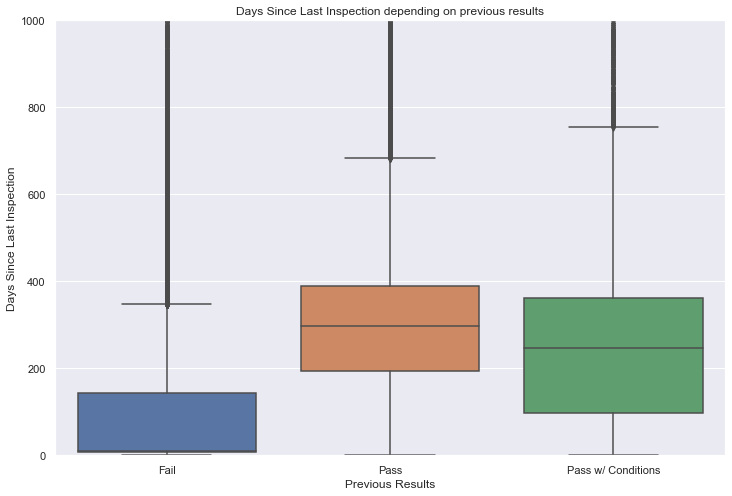

In [134]:
sns.set()
sns.boxplot(x='Previous Results',
            y='Days Since Last Inspection',
            data=pred).set_title('Days Since Last Inspection depending on previous results')
plt.ylim([0,1000])

We can see that the delay between two inspections is usually way much shorter when an establishment previously failed an inspection than when it passed. This is normal because inspections are supposed to be more frequent for establishment which fail or with high risk. We can also note that there is a high variability of delay for establishments which previously passed with conditions to undergo their next inspection. Finally, we have a lot of outliers but some reports of inspections might be missing, explaining the huge gap between two inspections sometimes.

<u>**Analysis of previous inspections**</u>

In [208]:
chart = pd.crosstab(pred['Previous Results'], pred['Results'])

fail_fail_probability = (chart.loc["Fail", "Fail"] /chart.loc["Fail",:].sum())
pass_fail_probability = ((chart.loc["Fail", "Pass"]) /chart.loc["Fail",:].sum())
passWC_fail_probability = ((chart.loc["Fail", "Pass w/ Conditions"]) /chart.loc["Fail",:].sum())
pass_pass_probability = (chart.loc["Pass", "Pass"] /chart.loc["Pass",:].sum())

print('{} of prior fails resulted in a subsequent fail'.format(fail_fail_probability*100))
print('{} of prior fails resulted in a subsequent pass'.format(pass_fail_probability*100))
print('{} of prior fails resulted in a subsequent pass with conditions'.format(passWC_fail_probability*100))
print('{} of prior passes resulted in a subsequent pass'.format(pass_pass_probability*100))

chart

11.063803337787862 of prior fails resulted in a subsequent fail
83.69332131646829 of prior fails resulted in a subsequent pass
5.242875345743854 of prior fails resulted in a subsequent pass with conditions
64.8662974054541 of prior passes resulted in a subsequent pass


Results,Fail,Pass,Pass w/ Conditions
Previous Results,,,
Fail,3560,26930,1687
Pass,16313,48952,10201
Pass w/ Conditions,2933,7374,2895


By plotting this crosstab, we can see that establishments are more likely to pass if they pass their last inspection. Interestingly, most establishments which failed their last inspection are more likely to pass probably because they fix what was bought to their attention to avoid anymore isssues. 

In [218]:
convert_dict = {'Violations': str}  
pred = pred.astype(convert_dict)

In [219]:
# Get a list of the different violations for each inspection. 
pred["Violations"] = pred.Violations.apply(lambda x : x.split("|"))
    
# Discard the comments.
pred["Violations"] = pred.Violations.apply(lambda x : [elt.split(" - Comments: ")[0] for elt in x])

# Join all the numbers in a string separated by |
pred["Violations"] = pred.Violations.apply(lambda x : "|".join([elt.split(".")[0].strip() for elt in x]))

In [220]:
pred=one_hot_encoding_violations(pred, list_of_violations1)
pred = pred.drop(columns=["Violations"])

pred=pred[pred['Results'].isin(['Pass','Fail','Pass w/ Conditions'])]

pred["Results"] = pred["Results"].map({'Fail':0, 'Pass w/ Conditions':1,'Pass':2})
pred["Previous Results"] = pred["Previous Results"].map({'Fail':0, 'Pass w/ Conditions':1,'Pass':2})

In [221]:
pred=pred.drop(['Inspection ID', 'License #','Inspection Date','Inspection Type','Facility Type'], axis=1)
pred.head()

,Risk,Results,Number of violations,Previous Results,Days Since Last Inspection,feature_34,feature_35,feature_33,feature_32,feature_38,...,feature_10,feature_4,feature_28,feature_20,feature_25,feature_7,feature_17,feature_5,feature_23,feature_15
22331,1.0,2,1.0,0.0,23.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22332,2.0,2,1.0,NaN,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22336,3.0,2,10.0,0.0,7.0,1,1,1,1,1,...,0,1,0,0,0,0,0,1,0,0
22337,3.0,2,8.0,0.0,7.0,1,1,1,0,1,...,0,1,0,0,0,0,0,1,0,0
22338,1.0,2,1.0,0.0,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [222]:
pred = pred.dropna()
y=pred['Results']
X=pred.drop(['Results'],axis=1)

# Split our data set into a train and a test data set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.86
Accuracy of K-NN classifier on test set: 0.80


In [225]:
# Train the model on the training set.
clf = MLPClassifier(solver='adam', hidden_layer_sizes=(10, 5), activation='relu', learning_rate='adaptive')\
        .fit(X_train, y_train)
                                                 
#Evaluate the model's accuracy on the test set.
clf.score(X_test, y_test)

0.9350407546857544

<h4> Comparison of the models </h4> 

The final step we took with our project is trying to see whether we can use the data we have in order to predict whether an inspection will pass or fail. We tried 4 different approaches for this problem, however, the main difference is not in the models we used, but in how we extract the features. The approach which stood out is using 'Term Frequency - Inverse Document Frequency' (TF-IDF) vectorizer to extract important words as features from the violations and comments. This is particularly suited for our dataset because it is robust to the change in violations that occurred in 2018. By training a Linear Support Vector Machine with these features and performing grid search to find the optimal hyperparameters, we obtained a high test accuracy of 96%.

On the other hand, the other approaches we attempted provided really good results as well. The first one consisted in converting the violations to binary features: 1 column corresponds to one violation and the value contained is 1 if the violation is resent in the current inspection, 0 otherwise. The limitation of this approach is that it requires us to split the dataset and train 2 different models on the first split containing the old violations and on the new split containing the new violations after 2018. By training a Multilayer Perceptron on the first split of the data (old violations) we obtained a test accuracy of 94%.

The second approach is somewhat similar in the sense that, aside from using only the violations, it also uses other binary features like ‘Inspection Type’, ‘Facility Type’ and the Latitude and Longitude as numerical features. Once again the dataset has to be split and 2 different models have to be trained. By training a simple Logistic Regression on these features we obtained a test accuracy of 93%.

Last but not least, the final approach we used is also similar. The only difference is that we derive some new features to use together with the violations: the result of the previous inspection, the number of days since the last inspection and the number of violations. Once again we trained an MLP and obtained a test accuracy of 93% and this is obtained with multiclass labeling. We also tried a simple KNN classifier which only achieved 80% test accuracy. Unfortunately, this approach also has the limitation of having to split the dataset in order to deal with the change in violations.

To optimize even further our prediction model, we should combine all the advantages of the previous models.

<h3> Conclusion and next steps </h3> 

After this first analysis, we can draw the following conclusions : 
- An interesting finding we came across by looking at the results of the inital analysis is the fact that, althoug most food establishments are categorised as having 'High Risk', a much larger proportion of the inspections pass rather than fail. To make matters worse, it seems that most inspections are of type 'Canvass' or 'License', and only a small percetage are based on complaints which means that the consumers are unware of the standards the establishments should meet, their own safety or, even worse, the establishments themselves hide their issues very well.
- Concerning seasonal patterns, inspections seem to get stricter after 2017, with a higher proportion of passed with conditions than passed inspections. The main reason is that the violations code changed in July 2018, thus implying a change in the way inspections are dealt with. If we take a look at the evolution of the results over the months, there is a clear increase in the fail proportion during summer : the risk of having temperature issues with the food, disfunctional thermostats or infestations (rodents, insects) is higher. Since these violations usually make inspections fail, it is normal to observe this increase.
- We shed light on how the different violations can be classfied in different categories (Minor, Severe and Critical), and how they contribute to the result of an inspection. We used this observation later on to build our models. 

<u><b> Next steps for Milestone 3 </b> </u>

* Create the Data Story : choose the platform (we would probably use Jekyll as recommended), get familiar with it,
* Keep the relevant data analysis and organize it in order to create a guideline for the 'story',
* Try to make our predictive models more visual (try to find a way to display our predictions), 
* Explore more the Folium functionalities in order to interactively represent our data, 
